In [ ]:
import numpy as np

DTYPE = np.float32

def int_exp_midpoint(N):
    interval = np.arange(0, N)
    result = 0
    h = np.float32(1.0 / N)
    for i in interval:
        result += np.exp(-(i + .5) * h, dtype=float) * h
    return result

def int_exp_trapezoidal(N):
    interval = np.arange(N - 1)
    result = 0
    h = np.float32(1.0 / N)
    for i in interval:
        result += np.exp(-h * (i + 1), dtype=np.float64) * np.float32(h)
    result += (1 + 1.0 / np.e) * 0.5 * h
    return result

def int_exp_simpson(N):
    interval = np.arange(N - 1)
    result = 0
    h = np.float32(1.0 / N)
    for i in interval:
        if (i + 1) % 2 == 0:
            result += np.float32(2.0) * np.exp(-(i + 1) * h, dtype=DTYPE) * h
        else:
            result += np.float32(4.0) * np.exp(-(i + 1) * h, dtype=DTYPE) * h
    return np.float32(1.0 / 3.0) * (h * (1 + 1 / np.e) + result)

N = 1e5
print("Integral of exp(-x) from 0 to 1 with midpoint rule and h =", N, "is", int_exp_midpoint(N))
print("Integral of exp(-x) from 0 to 1 with trapezoidal rule and h =", N, "is", int_exp_trapezoidal(N))
print("Integral of exp(-x) from 0 to 1 with Simpson's rule and h =" , N, "is", int_exp_simpson(N)) 
print("'Real' integral is", np.float32(1 - 1/np.e))

Integral of exp(-x) from 0 to 1 with midpoint rule and h = 100000.0 is 0.6321205495325045
Integral of exp(-x) from 0 to 1 with trapezoidal rule and h = 100000.0 is 0.6321205495402987
Integral of exp(-x) from 0 to 1 with Simpson's rule and h = 100000.0 is 0.63212204
'Real' integral is 0.63212055


In [1]:
import numba
import numpy as np

DTYPE = np.float32

@numba.njit(parallel=True)
def int_exp_midpoint(N):
    result = 0.0
    h = np.float32(1.0 / N)
    for i in numba.prange(N):
        result += np.float32(np.exp(-(i + 0.5) * h)) * np.float32(h)
    return np.float32(result)

@numba.njit(parallel=True)
def int_exp_trapezoidal(N):
    h = np.float32(1.0 / N)
    result = 0.0
    for i in numba.prange(N - 1):
        result += np.float32(np.exp(-(i + 1) * h)) * h
    result += np.float32(1 + 1.0 / np.e) * h / np.float32(2.0)
    return np.float32(result)

@numba.njit(parallel=True)
def int_exp_simpson(N):
    h = np.float32(1.0 / N)
    result = np.exp(0) + np.exp(-1)
    for i in numba.prange(N - 1):
        if (i + 1) % 2 == 0:
            result += np.float32(2) * np.float32(np.exp(-(i + 1) * h))
        else:
            result += np.float32(4) * np.float32(np.exp(-(i + 1) * h))
    return np.float32(result * h / 3.0)



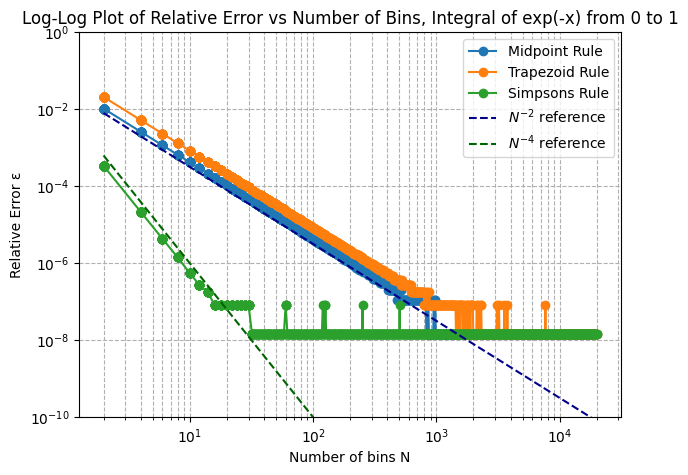

1.000001
1.0000001
1.0
1.0


In [3]:
import matplotlib.pyplot as plt

TRUE_INTEGRAL = 1.0 - 1.0 / np.e

@numba.njit(parallel=True)
def rel_error(g, N):
    errors = np.zeros(len(N))
    for i in numba.prange(len(N)):
        errors[i] = np.abs((g(N[i]) - TRUE_INTEGRAL) / TRUE_INTEGRAL)
    return errors

# def rel_error(g, N):
#     TRUE_INTEGRAL = 1.0 - 1.0 / np.e
#     errors = np.zeros(len(N), dtype=np.float64)
#     for i in range(len(N)):
#         errors[i] = np.abs((g(N[i]) - TRUE_INTEGRAL) / TRUE_INTEGRAL)
#     return errors

N_values = 2 * np.logspace(0, 4, 1000, dtype=np.int64)

plt.figure(figsize=(7,5))
plt.loglog(N_values, rel_error(int_exp_midpoint, N_values), marker='o', label='Midpoint Rule')
plt.loglog(N_values, rel_error(int_exp_trapezoidal, N_values), marker='o', label='Trapezoid Rule')
plt.loglog(N_values, rel_error(int_exp_simpson, N_values), marker='o', label='Simpsons Rule')
plt.loglog(N_values, 10**(-1.5) / N_values**(2), 
         linestyle='--', color='darkblue', label=r'$N^{-2}$ reference')
plt.loglog(N_values, 1e-2 / N_values**(4), 
         linestyle='--', color='darkgreen', label=r'$N^{-4}$ reference')
plt.ylim(1e-10, 1)
plt.xlabel('Number of bins N')
plt.ylabel('Relative Error ε')
plt.title('Log-Log Plot of Relative Error vs Number of Bins, Integral of exp(-x) from 0 to 1')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

print(np.float32(1 + 1 / 1e6))
print(np.float32(1 + 1 / 1e7))
print(np.float32(1 + 1 / 1e8))
print(np.float32(1 + 1 / 1e9))